In [120]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from helper_funcs import *

In [121]:
indir = '~/BC-fMRI-AE/Assets/data_preprocessed_sfari-run1/'
indir = os.path.expanduser(indir)

In [122]:
folders = os.listdir(indir)
folders.sort()
folders_names = [int(folder[-3::]) for folder in folders]
folders[0:5]

['sub-001', 'sub-002', 'sub-003', 'sub-005', 'sub-006']

In [123]:
sub_list = pd.DataFrame()
sub_list['subID'] = folders
sub_list['subNum'] = folders_names
sub_list

,subID,subNum
0,sub-001,1
1,sub-002,2
2,sub-003,3
3,sub-005,5
4,sub-006,6
...,...,...
178,sub-204,204
179,sub-205,205
180,sub-206,206
181,sub-207,207


In [124]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [125]:
#pd.DataFrame(folders).to_csv('../Data/lo.csv')

In [126]:
len(folders)

183

In [127]:
# Load the data

#fn_temp = '~/BC-fMRI-AE/Assets/data_preprocessed_f3/{sub}/'
#fn_temp = os.path.expanduser(fn_temp)
fn_temp = os.path.join(indir,'{sub}')

cmats = []
durations = []
cmats_rel1 = []
cmats_rel2 = []
for i,sub in tqdm(enumerate(folders)):
    cmats.append(np.load(os.path.join(fn_temp,'cmat_srf_{sub}.npy').format(sub=sub)))
    durations.append(np.load(os.path.join(fn_temp,'scan_duration_{sub}.npy').format(sub=sub)))
    try:
        cmats_rel1.append(np.load(os.path.join(fn_temp,'split_data_srf{sub}.npz').format(sub=sub))['cmat1'])
        cmats_rel2.append(np.load(os.path.join(fn_temp,'split_data_srf{sub}.npz').format(sub=sub))['cmat2'])
    except:
        cmats_rel1.append(np.zeros((51,51))*np.nan)
        cmats_rel2.append(np.zeros((51,51))*np.nan)
        
        
durations = np.array(durations)
cmats = np.array(cmats)
cmats_rel1 = np.array(cmats_rel1)
cmats_rel2 = np.array(cmats_rel2)

183it [00:00, 408.39it/s]


In [128]:
len(folders)

183

In [129]:
cmats.shape

(183, 51, 51)

In [130]:
(durations>4).sum()

128

In [131]:
sub_list['duration'] = durations

6


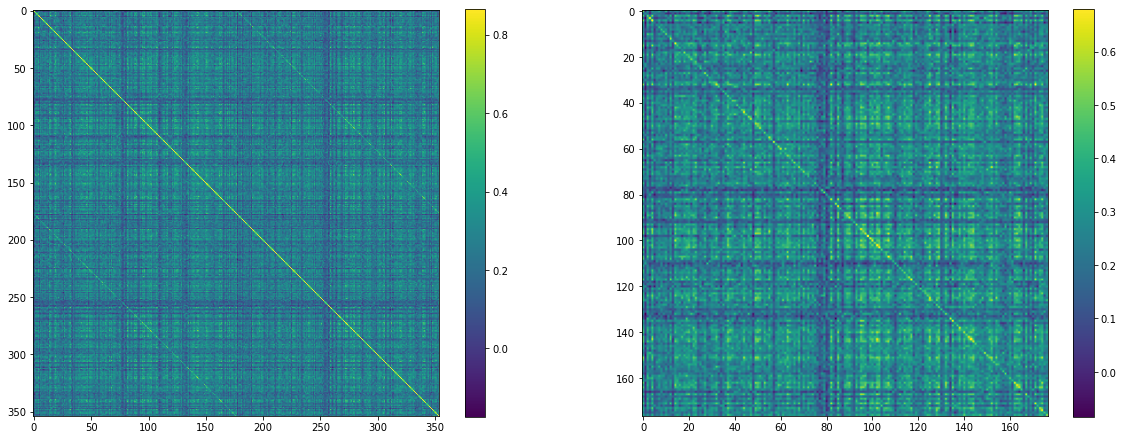

In [132]:
rel_cmat_flat_1 = flatten_cmat(cmats_rel1)
rel_cmat_flat_2 = flatten_cmat(cmats_rel2)

e = np.isnan(rel_cmat_flat_1).sum(axis=1)+np.isnan(rel_cmat_flat_2).sum(axis=1)>0
sub_list['rel_nan'] = e
print(e.sum())

rel_cmat_flat_1 = rel_cmat_flat_1[~e,:]
rel_cmat_flat_2 = rel_cmat_flat_2[~e,:]
n = rel_cmat_flat_1.shape[0]

rel_sim = np.corrcoef(np.vstack((rel_cmat_flat_1,rel_cmat_flat_2)))
sim_halves = rel_sim[0:n,n::]

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(rel_sim)
plt.clim(get_triu(rel_sim).min(),get_triu(rel_sim).max())
plt.colorbar(shrink=.75)

#plt.figure(figsize=(10,10))
plt.subplot(1,2,2)
plt.imshow(sim_halves)
plt.clim(get_triu(sim_halves).min(),get_triu(sim_halves).max())
plt.colorbar(shrink=.75)

In [133]:
ranks = np.array([np.argwhere(np.argsort(sim_halves[s,:])[-1::-1]==s)[0][0]+1 for s in range(n)])

In [134]:
sub_list['rank'] = np.nan
sub_list['rank'].values[~e] = ranks

In [135]:
np.median(ranks)

1.0

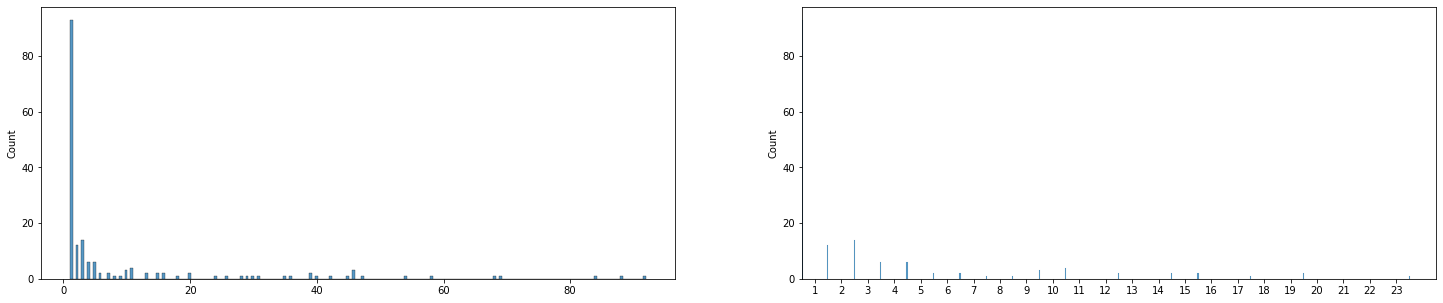

In [136]:
plt.figure(figsize=(25,5))
plt.subplot(1,2,1)
sns.histplot(ranks,bins=200)
plt.subplot(1,2,2)
sns.histplot(ranks,bins=2000)
plt.xlim(1,25);
plt.xticks(np.arange(1,24)+.5,labels=np.arange(1,24));

In [137]:
good_cmats = np.isnan(cmats).sum(axis=-1).sum(axis=-1)==0
sub_list['cmat_nan'] = ~good_cmats

In [138]:
cmats = cmats[good_cmats]

Text(0.5, 1.0, 'cmat similarity')

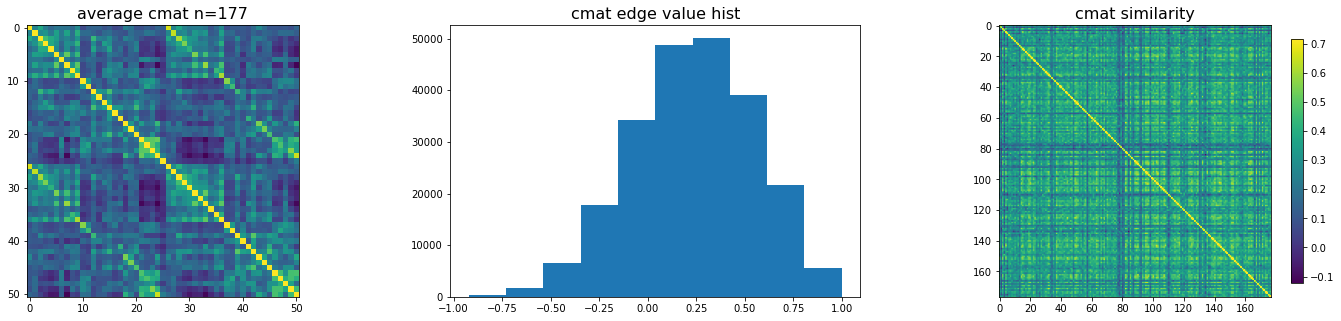

In [139]:
plt.figure(figsize=(25,5))

plt.subplot(1,3,1)
plt.imshow(cmats.mean(axis=0))
plt.title(f'average cmat n={cmats.shape[0]}',fontsize=16)

plt.subplot(1,3,2)
triu = np.triu_indices(n=51,k=1)
cmats_flat = np.array([cmats[i,:,:][triu] for i in range(cmats.shape[0])])
plt.hist(cmats_flat.flatten())
plt.title('cmat edge value hist',fontsize=16)


plt.subplot(1,3,3)
subcmat = np.corrcoef(cmats_flat)
subcmat_vec = subcmat[np.triu_indices(subcmat.shape[0],k=1)]

#plt.figure(figsize=(10,10))
plt.imshow(subcmat,vmin=subcmat_vec.min(),vmax=subcmat_vec.max())
plt.colorbar(shrink=.9)
plt.title('cmat similarity',fontsize=16)

In [140]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage

In [141]:
rlbls = pd.read_csv('../Data/YeoAtlas/roinames.txt',header=None,names=['rlbl'])['rlbl'].values

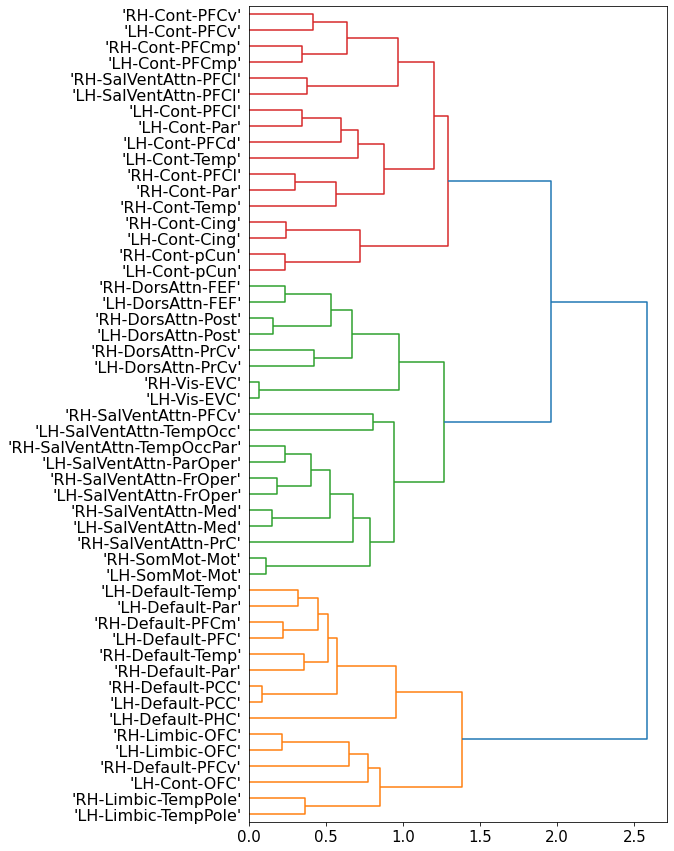

In [142]:
Z = linkage(1-get_triu(cmats.mean(axis=0)),'ward')
plt.figure(figsize=np.array((5,10))*1.5)
dendrogram(Z,orientation='right',labels=rlbls);
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=16)

In [143]:
df = pd.read_csv('../Data/sfari_df_S134.csv')

In [144]:
sub_good_dur = np.array(folders)[good_cmats][durations[good_cmats]>4]

In [145]:
unique_subs, count = np.unique(np.hstack((df['BIDS_ID'].values,sub_good_dur)),return_counts=True)

In [146]:
good_subs = unique_subs[count==2]

In [147]:
good_df = df.iloc[np.array([sub in good_subs for sub in df['BIDS_ID'].values])]
good_df

,Unnamed: 0,SFARI_ID,BIDS_ID,site,age_years,latest_clinical_asd_dx,svip_diagnosis_m1,family_type,genetic_status_16p,ados_module,...,measure_type,mother,relationship_to_iip,svip_neuro_exam.background.head_circum,svip_neuro_exam.background.head_circum_perc,svip_neuro_exam.background.head_circum_z_score,svip_neuro_exam.measure.eval_age_months,svip_neuro_exam.measure.measure_type,dur_run1,dur_run2
0,0,14702.x3,sub-001,60,8,False,non-spectrum-dx,16p-deletion,deletion,ados-2,...,diagnosis-summary,14702-x1,Initially identified proband,55.9,NaN,2.18,119.0,svip-neuro-exam,5.00,4.25
1,2,14705.x14,sub-003,50,34,False,no-diagnosis,16p-duplication,duplication,ados-4,...,diagnosis-summary,14705-x1,Mother,NaN,NaN,NaN,405.0,svip-neuro-exam,4.45,3.90
2,5,14714.x18,sub-006,60,21,False,no-diagnosis,16p-deletion,deletion,ados-4,...,diagnosis-summary,14714-x12,Initially identified proband,55.8,NaN,0.49,249.0,svip-neuro-exam,6.00,6.00
3,8,14723.x17,sub-009,60,5,False,non-spectrum-dx,16p-duplication,duplication,ados-2,...,diagnosis-summary,14723-x9,Initially identified proband,NaN,NaN,NaN,60.0,svip-neuro-exam,5.20,5.30
5,11,14725.x48,sub-012,60,35,False,non-spectrum-dx,16p-duplication,duplication,ados-4,...,diagnosis-summary,14725-x26,Father,52.5,NaN,-1.76,415.0,svip-neuro-exam,4.50,4.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,200,15048.x1,sub-201,50,13,False,NaN,non-familial-control,NaN,NaN,...,NaN,NaN,NaN,55.0,NaN,0.63,152.0,svip-neuro-exam,5.35,5.40
130,202,15060.x1,sub-203,50,28,False,NaN,non-familial-control,NaN,NaN,...,NaN,NaN,NaN,60.0,NaN,3.42,338.0,svip-neuro-exam,5.10,3.85
131,204,15071.x1,sub-205,60,28,False,NaN,non-familial-control,NaN,NaN,...,NaN,NaN,NaN,57.5,95.0,1.67,335.0,svip-neuro-exam,6.00,5.70
132,206,15083.x5,sub-207,50,12,False,non-spectrum-dx,16p-deletion,deletion,ados-3,...,diagnosis-summary,15083-x3,Initially identified proband,58.0,NaN,2.77,149.0,svip-neuro-exam,5.05,5.35


In [149]:
good_cmats_idx = np.array([sub in good_subs for sub in np.array(folders)[good_cmats]])
good_good_cmats = cmats[good_cmats_idx,:,:]

In [154]:
ofn = os.path.expanduser('~/BC-fMRI-AE/Data/cmats_SFARI_S121.npz')
ofn_csv = os.path.expanduser('~/BC-fMRI-AE/Data/sfari_df_S121.csv')

In [153]:
np.savez_compressed(ofn,cmats=good_good_cmats)

In [155]:
good_df.to_csv(ofn_csv)

In [32]:
# fmriprep_check = pd.read_csv('../Data/fmriprep_check.csv')
# dataset = [fmriprep_check['dataset'].values[fmriprep_check['subID'].values==sub][0] for sub in sub_list['subID'].values]
# sub_list['dataset'] = dataset

In [33]:
# u,c = np.unique(sub_list['subNum'].values,return_counts=True)
# sub_list['scaned_twice'] = sub_list['subNum'].isin(u[c>1])
# print(len(u[c>1]))

In [34]:
# sub_list.to_csv('../Data/sub_list_preprocessed4.csv')

In [35]:
## Concatenate legends

In [36]:
# unify = pd.read_csv('../Data/unify_abide_labels.csv')
# df_ab2 = pd.read_csv('../Data/ABIDE2_df.csv')
# df_ab1 = pd.read_csv('../Data/ABIDE_df3.csv')

# df_ab1_unified = df_ab1[unify['ABIDE1_label'].values].copy()
# df_ab1_unified = df_ab1_unified.set_axis(unify['unified_label'].values, axis=1, inplace=False)

# df_ab2_unified = df_ab2[unify['ABIDE2_label'].values].copy()
# df_ab2_unified = df_ab2_unified.set_axis(unify['unified_label'].values, axis=1, inplace=False)

In [37]:
# df_ab1_unified['dataset'] = 'ABIDE1'
# df_ab2_unified['dataset'] = 'ABIDE2'

In [38]:
# df_comb = pd.concat([df_ab1_unified,df_ab2_unified])
# df_comb.sort_values(by=['dataset','subID'],ascending=True,inplace=True)
# #df_comb.to_csv('../Data/df_comb_S2055.csv')
# df_comb

In [39]:
# # Add scan-site information
# subsite = []

# abide1_path = '~/data/ABIDE/RawDataBIDS/'
# abide2_path = '~/data/ABIDE2/RawData/'

# abide1_path = os.path.expanduser(abide1_path)
# abide2_path = os.path.expanduser(abide2_path)

# abide1_sites = os.listdir(abide1_path)
# abide1_sites.sort()

# abide2_sites = [folder for folder in os.listdir(abide2_path) if not folder.startswith('.')]
# abide2_sites.sort()

# # ABIDE I
# for site in abide1_sites:
#     site_subs = [sub for sub in os.listdir(os.path.join(abide1_path,site)) if sub.startswith('sub-')]
#     for site_sub in site_subs:
#         subsite.append([site_sub,site])
        
# # ABIDE II
# for site in abide2_sites:
#     site_subs = [sub for sub in os.listdir(os.path.join(abide2_path,site)) if sub.startswith('sub-')]
#     for site_sub in site_subs:
#         subsite.append([site_sub,site.replace('ABIDEII-','')])
        
# subsite = pd.DataFrame(subsite,columns=['sub','site'])

In [40]:
# unique_sites = np.unique(subsite['site'].values)
# unique_sites.sort()
# subsite['siteID'] = [np.argwhere(subsite['site'].values[s]==unique_sites)[0][0]+1 for s,_ in enumerate(subsite['site'])]
# subsite['subNum'] = [int(sub[-5::]) for sub in subsite['sub'].values]

In [41]:
# len(np.unique(subsite['sub'].values))

In [42]:
# subsite.sort_values(by="sub", ascending=1)

In [43]:
# sub_list = pd.read_csv('../Data/sub_list_preprocessed4.csv')
# df_comb = pd.read_csv('../Data/df_comb_S2055.csv')

In [44]:
# use_subjects = (~sub_list['scaned_twice'].values) * (~sub_list['cmat_nan'].values) * (sub_list['duration'].values>=4)
# sub_list_use = sub_list.iloc[use_subjects]

In [45]:
# print(len(sub_list_use))
# sub_list_use.head(5)

In [46]:
# print(len(df_comb))
# df_comb.head(5)

In [47]:
# assert np.unique(sub_list_use['subNum'].values,return_counts=True)[1].max()==1,'duplicate subjects in sub_list_use'
# assert np.unique(df_comb['subID'].values,return_counts=True)[1].max()==1,'duplicate subjects in df_comb'

In [48]:
# stack_subs = np.hstack(( sub_list_use['subNum'].values , df_comb['subID'].values ))
# unique_subs, count = np.unique(stack_subs,return_counts=True)
# common_subs = unique_subs[count==2]
# print(len(common_subs))

In [49]:
# df_comb_use = df_comb.iloc[df_comb['subID'].isin(common_subs).values]
# df_comb_use

In [50]:
# df_comb_use['siteID'] = [subsite[df_comb_use['subID'].values[s]==subsite['subNum'].values]['siteID'].values[0] for s in range(df_comb_use.shape[0])]

In [51]:
# def make_subID(s,df):
#     subNum = df['subID'].values[s]
#     subID = [f'sub-00{subNum:}' if df['dataset'].values[s]=='ABIDE1' else f'sub-{subNum:}'][0]
#     return subID

In [52]:
# df_comb_use['sub'] = [make_subID(s,df_comb_use) for s in range(df_comb_use.shape[0])]

In [53]:
# cmats = [np.load(f'../Assets/data_preprocessed_f3/{sub}/cmat_srf_{sub}.npy') for sub in tqdm(df_comb_use['sub'].values)]

In [54]:
# df_comb_use.to_csv('../Data/df_comb_S1558.csv')

In [55]:
# np.savez_compressed('../Data/cmats')

In [56]:
# '../df_comb_S1558.csv'